# Coexpression of ISGs under stimulation

In [182]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [183]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [184]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [185]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [186]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [187]:
adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [188]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [189]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [191]:
adata.shape

(69958, 36588)

In [192]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [193]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Define ISG classes

In [12]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [151]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

In [152]:
tf_df = pd.read_csv('../baseline/human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

In [153]:
# cytokines = pd.read_csv('../mart_export.txt')['Gene name'].tolist()
# cytokines = v_df.query('cytokine').gene.tolist()

### Setup memento

In [195]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [196]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [197]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

Version 0.0.6


In [198]:
# mhc_1 = []
# mhc_2 = []
# for g in included_de_genes:
#     if 'HLA' in g:
#         if len(g.split('-')[1]) > 1:
#             mhc_2.append(g)
#         else:
#             mhc_1.append(g)

### STAT1 differential correlation

In [199]:
to_test = []
for g in available_genes:
    if 'STAT' in g or 'IRF' in g:
        to_test.append(g)

In [203]:
cts = ['C', 'B', 'BC']
tps = ['6']
ct = ['C']
stims = ['gamma', 'beta']
for tp in tps:
    for stim in stims:
        
        adata_stim = adata.copy()[

            adata.obs.ct.isin(ct) & \
            adata.obs.stim.isin([stim, 'control']) & \
            adata.obs.time.isin(['0', tp])].copy()
        
        time_converter={0:0, int(tp):1}
        adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
        adata_stim.obs['group'] = 1

        memento.create_groups(adata_stim, label_columns=['donor', 'time_step'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.9)

        available_genes = adata_stim.var.index.tolist()
#         to_test = []
#         for g in available_genes:
#             if 'STAT' in g or 'IRF' in g:
#                 to_test.append(g)
                
#         available_genes = list(   set(available_genes)  - set(to_test) )
        
        memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1', 'STAT2', 'IRF9'], available_genes)))
        
        moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
        
        candidates = moment_df.query('time_step_0 > 0.3 | time_step_1 > 0.3')
        print(stim, tp, candidates.shape)
        memento.compute_2d_moments(adata_stim, list(zip(candidates['gene_1'], candidates['gene_2']))  )
                
        memento.ht_2d_moments( 
            adata_stim, 
            formula_like='1 + donor + time_step',
            treatment_col='time_step', 
            num_boot=10000, 
            verbose=1,
            num_cpus=94,
            resampling='permutation',
            approx=False)

        adata_stim.write(data_path + 'differential_utilization/{}_{}.h5ad'.format(stim, tp))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


gamma 3 (4024, 4)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    7.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   17.7s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   33.0s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   50.4s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  1.1min
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  1.4min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  1.9min
[Parallel(n_jobs=94)]: Done 4020 out of 4020 | elapsed:  2.5min finished
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


beta 3 (5700, 4)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   15.1s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   32.5s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   55.6s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  1.4min
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  1.7min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  2.1min
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:  2.7min
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:  3.3min
[Parallel(n_jobs=94)]: Done 5695 out of 5695 | elapsed:  4.0min finished
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future v

gamma 48 (4097, 4)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   10.3s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   22.1s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   37.7s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   50.1s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  1.1min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  1.5min
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:  2.0min
[Parallel(n_jobs=94)]: Done 4093 out of 4093 | elapsed:  2.1min finished
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/s

beta 48 (3859, 4)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.5s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   11.3s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   24.2s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   39.5s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   53.3s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  1.2min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  1.6min
[Parallel(n_jobs=94)]: Done 3854 out of 3854 | elapsed:  2.1min finished
... storing 'memento_group' as categorical


In [163]:
to_test = list(set(tf_list) & set(available_genes))

In [54]:
# First, get correlations without adjustment
stim = 'gamma'
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin([stim, 'control']) & \
    adata.obs.time.isin(['0', '3'])].copy()
time_converter={0:0, int('3'):1}
adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
adata_stim.obs['group'] = 1

memento.create_groups(adata_stim, label_columns=['donor', 'time_step'])
memento.compute_1d_moments(adata_stim, min_perc_group=.3)

available_genes = adata_stim.var.index.tolist()

# memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_genes)))
# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time_step')
# candidates = moment_1d_df.query('time_step_0 > 0.35 | time_step_1 > 0.35')
memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1', 'STAT2', 'IRF9'], available_genes)))
c_df = memento.get_2d_moments(adata_stim, groupby='time_step')
c_df['es'] = c_df['time_step_1'] - c_df['time_step_0']
c_df = c_df.merge(isg_classes, left_on='gene_2', right_on='gene')

sns.boxplot(x='gene_1', y='es', hue='overall_type',data=c_df.query('overall_type != "shared"'))
memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + donor + time_step',
    treatment_col='time_step', 
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='permutation',
    approx=False)

rho_adj = memento.get_2d_ht_result(adata_stim)

# adata_stim.write(data_path + '{}_6_dc.h5ad'.format(stim))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [33]:
adata_stim.write(data_path + 'gamma_6_dc.h5ad')

... storing 'memento_group' as categorical


In [34]:
moment_1d_df = memento.get_2d_moments(adata_stim, groupby='time_step')
candidates = moment_1d_df.query('time_step_0 > 0.3 | time_step_1 > 0.3')

In [35]:
len(candidates)

1831

In [135]:
corr_df = memento.get_2d_ht_result(adata_stim)
# corr_df = corr_df.merge(candidates[['gene_1', 'gene_2']], on=['gene_1', 'gene_2'])
corr_df['dc_fdr'] = memento.util._fdrcorrect(corr_df['corr_pval'])
isg_corr_df = corr_df.merge(isg_classes[['gene', 'overall_type']], left_on='gene_2', right_on='gene')

<AxesSubplot:xlabel='overall_type', ylabel='corr_coef'>

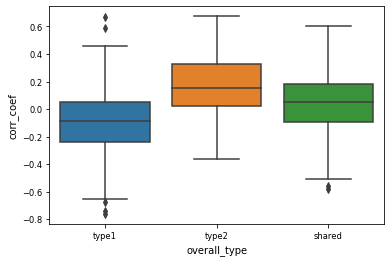

In [143]:
sns.boxplot(x='overall_type', y='corr_coef', data=isg_corr_df)

In [142]:
isg_corr_df.shape

(430, 8)

In [136]:
dc_genes = isg_corr_df.query('dc_fdr < 0.1 & corr_coef > 0').gene_2.tolist()

In [137]:
corr_df.shape

(11316, 6)

In [138]:
'IFIT1' in dc_genes

False

In [139]:
len(dc_genes)

29

In [140]:
dc_genes

['GBP3',
 'GBP2',
 'WDFY1',
 'TF',
 'CXCL9',
 'IRF1',
 'CD74',
 'HLA-E',
 'HLA-B',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DQB1',
 'HLA-DMA',
 'HLA-DPA1',
 'HLA-DPB1',
 'CALHM6',
 'MDK',
 'PLAAT4',
 'TAPBPL',
 'AQP5',
 'N4BP2L1',
 'PSME2',
 'PDIA3',
 'MSRB1',
 'MMP25-AS1',
 'MT1E',
 'NLRC5',
 'SCO2',
 'SLC6A8']

### Heatmap for correlations at stim

In [101]:
ct = 'C'
stim = adata[(adata.obs.stim=='gamma') & adata.obs.ct.isin([ct])].copy().copy()
stim.obs['group'] = 1
memento.create_groups(stim, label_columns=['group', 'ct'])
memento.compute_1d_moments(stim, min_perc_group=.9) 

In [102]:
included_de_genes = list(set(dc_genes) & set(stim.var.index))

In [103]:
memento.compute_2d_moments(stim, gene_pairs=list(itertools.combinations(included_de_genes,2)))
c_df = memento.get_2d_moments(stim, groupby='ct')

In [104]:
ct_c_df = c_df[['gene_1', 'gene_2', 'ct_C']]
ct_heatmap = pd.DataFrame(np.zeros((len(included_de_genes), len(included_de_genes))), columns=included_de_genes, index=included_de_genes)
for idx, row in ct_c_df.iterrows():
    
    ct_heatmap.loc[row['gene_1'], row['gene_2']] = row['ct_C']
    ct_heatmap.loc[row['gene_2'], row['gene_1']] = row['ct_C']

In [109]:
# Manual construction of linkage matrix
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster


row_linkage = hierarchy.linkage(distance.pdist(ct_heatmap), method='average')
cluster_assignments = fcluster(row_linkage, t=10, criterion='maxclust')
num_clusters = 5
top_clusters= dict(zip(pd.Series(cluster_assignments).value_counts().head(num_clusters).index, range(num_clusters)))
top_clusters_reverse= dict(zip(range(num_clusters), pd.Series(cluster_assignments).value_counts().head(num_clusters).index, ))

coarse_cluster_assignments = np.array([top_clusters[i] if i in top_clusters else -1 for i in cluster_assignments])

In [110]:
print(ct_heatmap.shape)
cg = sns.clustermap(ct_heatmap.fillna(0.0), center=0, vmax=0.3, metric='euclidean', row_linkage=row_linkage, col_linkage=row_linkage); plt.close()
row_inds = cg.dendrogram_row.reordered_ind
col_inds = cg.dendrogram_col.reordered_ind
print(ct_heatmap.shape)


(29, 29)
(29, 29)


In [111]:
def classify_color_isg(x):
    
    if x in shared_isg:
        return -1
    if x in t1_isg:
        return 0
    if x in t2_isg:
        return 1
    return 'impossible'

In [112]:
# For ISG type coloring
from matplotlib.colors import LinearSegmentedColormap

myColors = sns.color_palette('Paired', num_clusters+1)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
class_list = coarse_cluster_assignments[np.newaxis, :]

In [113]:
myColors

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

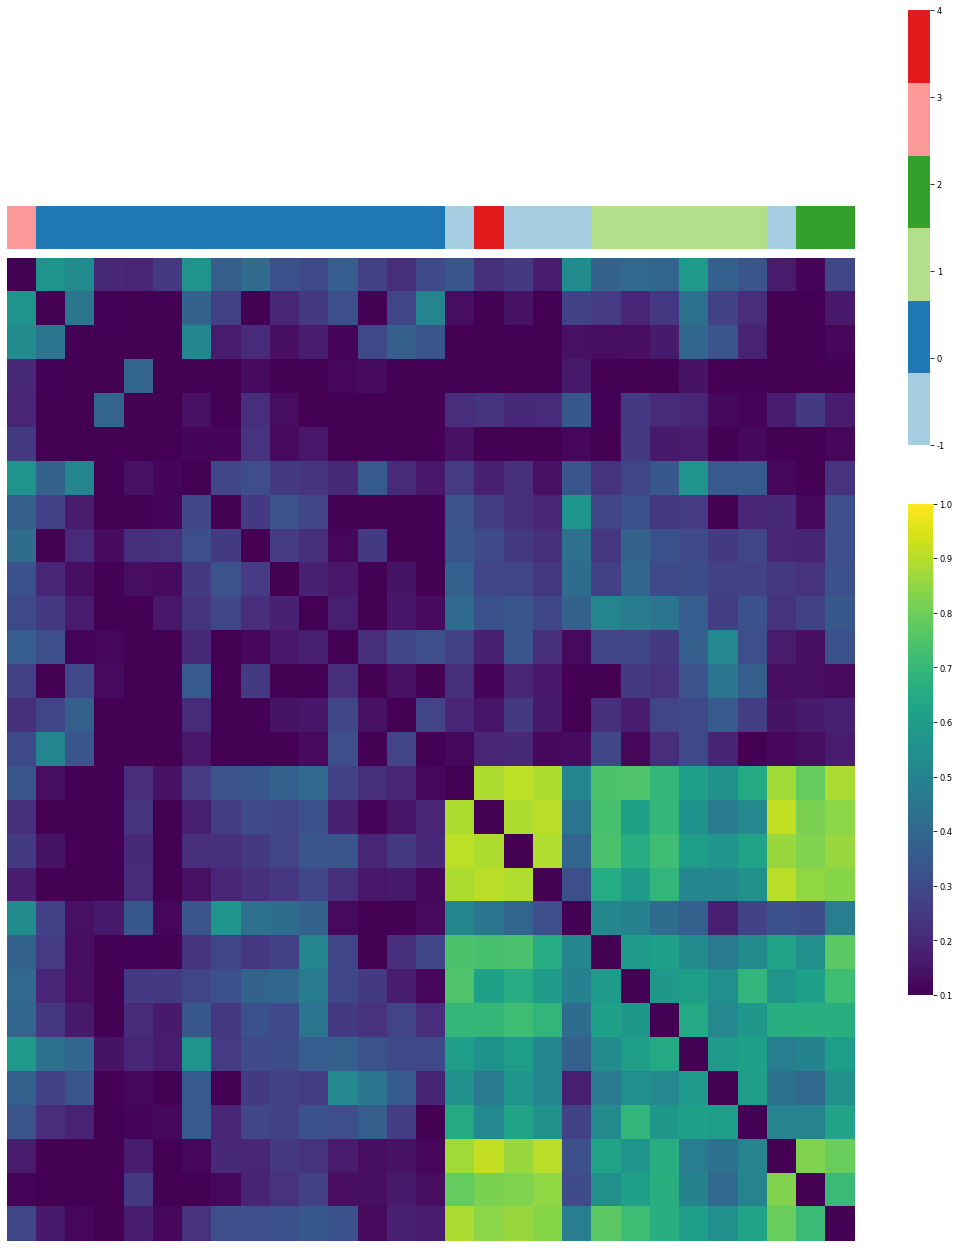

In [115]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((21,20), (1,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((21,20), (0,0), colspan=19, rowspan=1)

sns.heatmap(ct_heatmap.iloc[row_inds, col_inds], cmap='viridis', vmax=1, vmin=0.1, ax=ax1, yticklabels=False, xticklabels=False, cbar_kws={"shrink": 0.5})
sns.heatmap(class_list[:, row_inds], cmap=cmap, ax=ax2, yticklabels=False, xticklabels=False, cbar_kws={"shrink": 10})
colorbar = ax2.collections[0].colorbar
colorbar.set_ticks([-1] + list(range(num_clusters+1)))
colorbar.set_ticklabels([-1] + list(range(num_clusters+1)))

# colorbar.set_ticklabels(['shared', 'type1', 'type2'])

# some_genes = list(set(mhc_1)&set(included_de_genes))
# for g in some_genes:
#     idx = np.where(np.array(row_inds)==ct_heatmap.index.get_loc(g))[0][0]
#     ax1.plot([0, len(included_de_genes)], [idx, idx], color='magenta')
#     ax1.plot([idx, idx],[0, len(included_de_genes)], color='magenta',)
    
# selected_genes = {}
# locations = [
 
# ]
# colors = sns.color_palette('husl', len(locations))
# i = 0

# for x1, x2 in locations:
    
#     ax1.plot([x1, x1],[0, len(included_de_genes)], color=colors[i],)
#     ax1.plot([x2, x2],[0, len(included_de_genes)], color=colors[i])

#     selected_genes[i]= ct_heatmap.index[np.array(row_inds)[x1:x2]]
    
#     i+=1

In [116]:
gene_sets = {}
for cluster in range(10):
    
    gene_sets[cluster] = ct_heatmap.index[cluster_assignments == top_clusters_reverse[cluster]].tolist()
    print(cluster, gene_sets[cluster])

0 ['MT1E', 'AQP5', 'TF', 'IRF1', 'MSRB1', 'N4BP2L1', 'SLC6A8', 'NLRC5', 'WDFY1', 'SCO2', 'CXCL9', 'MMP25-AS1', 'CALHM6', 'TAPBPL']
1 ['PSME2', 'GBP3', 'HLA-E', 'PDIA3', 'PLAAT4', 'HLA-DQB1']
2 ['HLA-B', 'HLA-DMA']
3 ['GBP2']
4 ['HLA-DPB1']


KeyError: 5

In [86]:
moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')

In [88]:
moment_df.query('gene_2 in @t1_isg')

,gene_1,gene_2,time_step_1,time_step_0
5,STAT1,HES4,0.124738,0.135739
6,STAT1,ISG15,0.484757,0.713398
34,STAT1,NADK,0.010633,-0.154746
178,STAT1,ID3,-0.007875,0.010791
230,STAT1,IFI6,0.427060,0.580144
242,STAT1,PHACTR4,0.502576,0.464792
261,STAT1,COL16A1,-0.026593,0.129408
298,STAT1,NCDN,0.044874,0.055736
379,STAT1,SLC6A9,0.164095,0.171380
468,STAT1,CYP2J2,0.115890,-0.024032


In [169]:
ct = ['C']
tps = ['3', '6', '9', '24', '48']
for tp in tps:
    adata_stim = adata.copy()[

        adata.obs.ct.isin(ct) & \
        adata.obs.stim.isin(['beta', 'gamma']) & \
        adata.obs.time.isin(['3'])].copy()
    time_converter={0:0, int('3'):1}
    stim_converter={'beta':0, 'gamma':1}
    # adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['stim_indicator'] = adata_stim.obs['stim'].apply(lambda x: stim_converter[x])

    adata_stim.obs['group'] = 1

    memento.create_groups(adata_stim, label_columns=['donor', 'stim_indicator', 'time'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.3)
    m_df, c_df = memento.get_1d_moments(adata_stim, groupby='stim_indicator')

    available_genes = adata_stim.var.index.tolist()

    # memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_genes)))
    # moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time_step')
    # candidates = moment_1d_df.query('time_step_0 > 0.35 | time_step_1 > 0.35')
    memento.compute_2d_moments(adata_stim, list(itertools.product(to_test, list(set(available_genes)-set(to_test)))))
    c_df = memento.get_2d_moments(adata_stim, groupby='stim_indicator')
    #     c_df['es'] = c_df['time_step_1'] - c_df['time_step_0']

    result = c_df.merge(m_df, left_on='gene_2', right_on='gene', suffixes=('_c', '_m'))


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide


In [79]:
def get_correlation():
    
    ct = ['C']
    tf = 'STAT1'
    adata_stim = adata.copy()[

        adata.obs.ct.isin(ct) & \
        adata.obs.stim.isin([stim, 'control'])].copy()
    time_converter={0:0, int('3'):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['group'] = 1

    memento.create_groups(adata_stim, label_columns=['donor', 'time_step'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.3)
    m_df, c_df = memento.get_1d_moments(adata_stim, groupby='stim')

    available_genes = adata_stim.var.index.tolist()

    # memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_genes)))
    # moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time_step')
    # candidates = moment_1d_df.query('time_step_0 > 0.35 | time_step_1 > 0.35')
    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1', 'STAT2', 'IRF9', 'STAT3'], available_genes)))
    c_df = memento.get_2d_moments(adata_stim, groupby='time_step')
#     c_df['es'] = c_df['time_step_1'] - c_df['time_step_0']
    c_df = c_df.merge(isg_classes, left_on='gene_2', right_on='gene')
    c_df['stim'] = stim

    return c_df

In [80]:
gamma_corr = get_correlation('gamma')
beta_corr = get_correlation('beta')
corr = pd.concat([gamma_corr, beta_corr])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide


<AxesSubplot:xlabel='overall_type', ylabel='time_step_1'>

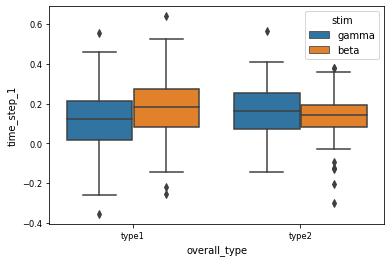

In [84]:
tf = 'STAT3'
sns.boxplot(x='overall_type', y='time_step_1', hue='stim',data=corr.query('overall_type != "shared" & gene_1 == "{}"'.format(tf)))


In [ ]:
corr.head(5)

In [68]:
tf = 'IRF9'
stats.ks_2samp(
    merged_corr.query('gene_1=="{}" & overall_type == "type1"'.format(tf)).time_step_1_beta,
    merged_corr.query('gene_1=="{}" & overall_type == "type1"'.format(tf)).time_step_1_gamma)

KstestResult(statistic=0.18771331058020477, pvalue=6.285550898502559e-05)

### Pick out genes and run memento

In [36]:
tf_df = pd.read_csv('../baseline/human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

In [35]:
'NLRC5' in tf_list

False

In [30]:
gene_sets = {}
for cluster in [9, 8, 6, 7, 14]:
    
    gene_sets[cluster] = ct_heatmap.index[cluster_assignments == top_clusters_reverse[cluster]].tolist()

In [98]:

gene_set_results = {}

for gs_idx, gene_set in gene_sets.items():
    
    print('Starting', gene_set, '---------------------------------------------')

    stim = 'gamma'
    ct = 'C'
    adata_stim = adata.copy()[

        adata.obs.ct.isin([ct]) & \
        adata.obs.stim.isin([stim])].copy()
    adata_stim.obs['group'] = 1

    memento.create_groups(adata_stim, label_columns=['donor', 'group'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)

    available_tfs = list(set(tf_list) & set(adata_stim.var.index))
    available_isgs= list(set(gene_set) & set(adata_stim.var.index))

    # moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

    memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))
    corr_df = memento.get_2d_moments(adata_stim, groupby='group')

    tf_avg_corrs = corr_df.groupby('gene_1').group_1.mean().sort_values(ascending=False)
    top_tfs = tf_avg_corrs[tf_avg_corrs > 0.25].index.tolist()

    num_strata = 5

    gene_set_results[gs_idx] = {}

    for tf in top_tfs:
        
        adata_stim = adata.copy()[
            adata.obs.ct.isin([ct]) & \
            adata.obs.stim.isin([stim])].copy()
        
        print('     working on ', tf)
        expr = adata_stim[:, tf].X.todense().A1
        try:
            discretized = pd.qcut(pd.Series(expr), q=num_strata, labels=range(num_strata),duplicates='raise').values
        except:
            discretized = pd.Series(expr != 0).astype(int).values
        
        adata_stim.obs['tf_strata'] = discretized
        
        memento.create_groups(adata_stim, label_columns=['donor', 'tf_strata'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.7)

        memento.compute_2d_moments(adata_stim, list(itertools.combinations(available_isgs, 2)))
    
        memento.ht_2d_moments( 
            adata_stim, 
            formula_like='1 + donor + tf_strata',
            treatment_col='Inter', 
            num_boot=10000, 
            verbose=1,
            num_cpus=94,
            resampling='bootstrap',
            approx=False)

        memento.get_2d_ht_result(adata_stim).to_csv(data_path + 'adjustment/{}_{}.csv'.format(gs_idx, tf), index=False)

Starting ['UBE2L6', 'IFI30', 'IFITM3', 'NMI', 'GSTK1', 'PSMB9', 'BST2', 'PLAAT4', 'GBP3', 'PSME2', 'PSMB10', 'IFITM1', 'PSMB8', 'PSME1'] ---------------------------------------------


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.1s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.2s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  SP110


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.9s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  SP100


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.3s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  RBCK1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.1s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.5s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  HMGB1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.5s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  PLSCR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.8s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  SUB1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.5s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  IRF2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.4s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  CENPX


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.4s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ETV7


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.5s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  IRF9


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.8s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.0s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  NME2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.4s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  MBD2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.0s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.1s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  CSDE1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.8s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.9s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  CAMTA1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.1s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.3s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  PARP12


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.3s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.6s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  PAX9


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.6s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.8s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.0s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ZNF706


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.5s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  YY1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  TAX1BP1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:106: RuntimeWarning: divide by zero encountered in log
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.8s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.9s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  CNBP


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.3s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  KLF5


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.6s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.9s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  NFE2L2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.6s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  MAX


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.5s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  YBX1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.8s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    6.9s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  NFE2L3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.9s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.3s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  TSC22D1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.9s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.2s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  DNAJC1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.6s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  BBX


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.5s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  PHB


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.5s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ZNF511


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.4s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  MLX


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.5s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  RFX5


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.5s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ZFP36L1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.0s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.1s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ZNF618


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.9s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.1s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  TOX3


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  STAT2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.9s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  LITAF


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  HES4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.6s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  BATF


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of  91 | elapsed:    6.9s remaining:    0.2s
[Parallel(n_jobs=94)]: Done  91 out of  91 | elapsed:    7.1s finished


Starting ['BTN3A2', 'HLA-DQB1', 'HLA-DMA', 'HLA-DPB1', 'HLA-F', 'HLA-B', 'HLA-A', 'HLA-DRB1', 'CD74', 'HLA-DPA1', 'HLA-DMB', 'HLA-C', 'HLA-DRA', 'PDIA3', 'HLA-DOA'] ---------------------------------------------


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.4s remaining:   14.8s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    8.1s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ATF4


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.4s remaining:   14.8s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    8.0s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  RFX5


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.3s remaining:   14.4s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    7.5s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  SP100


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.2s remaining:   14.1s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    7.5s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  CEBPB


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.5s remaining:   15.1s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    7.6s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  NR2F6


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.4s remaining:   14.7s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    7.9s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ELF3


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.6s remaining:   15.5s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    7.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  STAT2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.6s remaining:   15.4s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    7.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ZNF672


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.3s remaining:   14.4s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    8.1s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  PAX9


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.1s remaining:   13.8s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    8.0s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  MBD2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.1s remaining:   14.0s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    8.3s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  CIITA


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.2s remaining:   14.3s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    7.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  CSDE1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.7s remaining:   15.7s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    8.1s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  ID1


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  24 out of 105 | elapsed:    4.3s remaining:   14.6s
[Parallel(n_jobs=94)]: Done 105 out of 105 | elapsed:    7.7s finished


Starting ['EPSTI1', 'OPTN', 'SLC25A28', 'NUB1', 'TNFSF13B', 'IFIT3', 'CASP1', 'SP100', 'IFI16', 'IFI44L', 'ISG20', 'TRIM22', 'IFI44', 'IFIH1', 'IFI35', 'SP110', 'OAS3'] ---------------------------------------------


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


     working on  SP100


KeyError: 'SP100'

In [91]:
tf_avg_corrs = corr_df.groupby('gene_1').group_1.mean().sort_values(ascending=False)
top_tfs = tf_avg_corrs[tf_avg_corrs > 0.25].index.tolist()

In [95]:

for tf in top_tfs:
    tf = 'RFX5'
    expr = adata_stim[:, tf].X.todense().A1
    try:
        discretized = pd.qcut(pd.Series(expr), q=num_strata, labels=range(num_strata),duplicates='raise').values
    except:
        discretized = pd.Series(expr != 0).astype(int).values
    break

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [93]:
for t in available_tfs:
    
    t = 'STAT1'
    expr = adata_stim[:, t].X.todense().A1
    bins = np.linspace(0, expr.max(), 3)
    classes = np.digitize(expr, bins)
    
    break

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [94]:
pd.qcut(pd.Series(expr), q=4, labels=range(4),duplicates='raise').value_counts()

0    1019
1     970
3     796
2     647
dtype: int64

In [79]:
pd.qcut(pd.Series(expr), q=4, labels=list(range(4))).value_counts()

0    1019
1     970
3     796
2     647
dtype: int64

(array([2.139e+03, 5.650e+02, 3.170e+02, 2.940e+02, 5.900e+01, 3.000e+01,
        2.200e+01, 3.000e+00, 2.000e+00, 1.000e+00]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

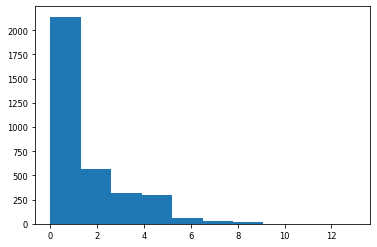

In [55]:
plt.hist(adata_stim[:, 'STAT2'].X.todense().A1)

In [48]:
corr_df.groupby('gene_1').group_1.mean().sort_values(ascending=False).head(100)

gene_1
STAT1       0.402290
ATF4        0.354942
RFX5        0.334734
SP100       0.333218
CEBPB       0.310522
NR2F6       0.300047
ELF3        0.292823
STAT2       0.289915
ZNF672      0.288805
PAX9        0.270205
MBD2        0.267381
CIITA       0.261883
CSDE1       0.254442
ID1         0.253570
RBCK1       0.242807
XBP1        0.242522
ZFP36L1     0.238454
PARP12      0.237730
KLF5        0.237336
RELB        0.236929
KLF3        0.235352
USF1        0.235237
NFE2L3      0.234522
PBX2        0.232134
NFIC        0.230226
DNAJC1      0.229701
CENPX       0.229657
TOX3        0.223552
SP1         0.221943
SPDEF       0.219686
HES4        0.216630
BATF        0.214122
NFKB2       0.213327
ARID5B      0.212547
CEBPD       0.212357
AHR         0.210425
KLF4        0.209886
EHF         0.209837
ZNF358      0.207379
DBP         0.205558
IRF3        0.205385
ZNF618      0.204397
IRF9        0.204255
NR2F2       0.203245
IRF2        0.202391
WIZ         0.199928
ZNF644      0.197271
PRRX2 